In [1]:
basedir = '/home/abhinavgupta0110/generalized_nCM'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'generalized_nCMs'))

%load_ext autoreload

### Load modules

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDistDDE_train_HOTs as ncm
import src.burgers_eqn_case_findiff.burgers_eqn as burg
from src.burgers_eqn_case_findiff.burgers_eqn_helper_classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import scipy as spy
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from shutil import move
import pickle

print(tf.__version__)

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

2.5.0


## Define some useful classes

### Class for user-defined arguments

In [4]:
class burg_ncm_args(ncm.ncm_arguments, burg.burg_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, 
                 decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 tau_max = 1.1, tau = 0.2,
                 model_dir = 'ROM_nDistDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2., nt = 200, 
                 train_ens_size = 1, x_left = [0.], x_right = [1.], nx_train_hf = [100], nx_train_lf = [25], Re = [250], 
                 dleft_bv_dt = [0.], dright_bv_dt = [0.], dbc_l = [1], nbc_l = [0], dbc_r = [1], nbc_r = [0],
                 isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'dopri5', nsteps = 1, ens_to_plot = -1, read_hf_data = 0, read_hf_data_fac = 4, 
                 use_analytical_sol = 0, lambda_l1_mark = 0., lambda_l2_mark = 0., 
                 lambda_l1_non_mark = 0., lambda_l2_non_mark = 0., prune_thres = 0., mse_weight = 0., max_deriv = 2,
                 acc = 2, acc_advec = 1, norm_Re = 1000, norm_nx = 50): # add more arguments as needed
        
        ncm.ncm_arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, 
                           tau_max = tau_max, tau = tau, model_dir = model_dir, restart = restart, val_percentage = val_percentage, 
                           isplot = isplot, is_tstart_zero = is_tstart_zero)
        
        self.args_train_hf = []
        for i in range(train_ens_size):
            self.args_train_hf.append(burg.burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_hf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv, 
                                         acc = acc, acc_advec = acc_advec))
            
        self.args_train_lf = []
        for i in range(train_ens_size):
            self.args_train_lf.append(burg.burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_lf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec))
        
        self.train_ens_size = train_ens_size
        i = ens_to_plot
        self.args_eval_hf = burg.burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_hf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec)
        self.args_eval_lf = burg.burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_lf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec)
        
        self.args_norm = burg.burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = norm_nx, Re = norm_Re, 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec)
        
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps
        self.read_hf_data = read_hf_data
        self.read_hf_data_fac = read_hf_data_fac
        self.use_analytical_sol = use_analytical_sol
        
        self.lambda_l1_mark = lambda_l1_mark
        self.lambda_l2_mark = lambda_l2_mark
        self.lambda_l1_non_mark = lambda_l1_non_mark
        self.lambda_l2_non_mark = lambda_l2_non_mark
        self.prune_thres = prune_thres
        self.mse_weight = mse_weight

In [5]:
### Define a custom plotting function
class custom_plot:

    def __init__(self, true_y, y_no_nn, x, t, figsave_dir, args, restart = 0):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.figsave_dir = figsave_dir
        self.args = args
        self.X, self.T = np.meshgrid(x.numpy(), t.numpy())
        self.x = x
        self.restart = restart


            
    def plot(self, *pred_y, epoch = 0):
        fig = plt.figure(figsize=(14, 10), facecolor='white')
        ax_u_lowres = fig.add_subplot(221)
        ax_u_diff = fig.add_subplot(222)
        ax_u_nn = fig.add_subplot(223)
        ax_u_diff_nn = fig.add_subplot(224)
        
        ax_u_lowres.cla()
        ax_u_lowres.set_title('Low-Res Solution', fontsize=14)
        ax_u_lowres.set_xlabel('x', fontsize=14)
        ax_u_lowres.set_ylabel('t', fontsize=14)
        plot = ax_u_lowres.contourf(self.X, self.T, tf.squeeze(self.y_no_nn, axis=1).numpy(), cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 0.5, 20), extend='min')
        ax_u_lowres.set_xlim(self.x[0], self.x[-1])
        ax_u_lowres.set_ylim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)

        ax_u_diff.cla()
        ax_u_diff.set_title('|Difference without NN|', fontsize=14)
        ax_u_diff.set_xlabel('x', fontsize=14)
        ax_u_diff.set_ylabel('t', fontsize=14)
        plot = ax_u_diff.contourf(self.X, self.T, tf.abs(tf.squeeze(self.true_y - self.y_no_nn, axis=1)).numpy(), cmap=plt.get_cmap('coolwarm'),
                            antialiased=False, levels=np.linspace(0, 0.25, 20))
        ax_u_diff.set_xlim(self.x[0], self.x[-1])
        ax_u_diff.set_ylim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax_u_diff, shrink=0.5, aspect=10)
        
        if epoch >= 0 or self.restart == 1 :
            ax_u_nn.cla()
            ax_u_nn.set_title('Low-Res with nCM Solution', fontsize=14)
            ax_u_nn.set_xlabel('x', fontsize=14)
            ax_u_nn.set_ylabel('t', fontsize=14)
            plot = ax_u_nn.contourf(self.X, self.T, tf.squeeze(pred_y[0][:, :, 0:self.args.state_dim], axis=1).numpy(), cmap=cm.coolwarm,
                               antialiased=False, levels=np.linspace(0, 0.5, 20), extend='min')
            ax_u_nn.set_xlim(self.x[0], self.x[-1])
            ax_u_nn.set_ylim(self.t[0], self.t[-1])
            plt.colorbar(plot, ax=ax_u_nn, shrink=0.5, aspect=10)

            ax_u_diff_nn.cla()
            ax_u_diff_nn.set_title('|Difference|', fontsize=14)
            ax_u_diff_nn.set_xlabel('x', fontsize=14)
            ax_u_diff_nn.set_ylabel('t', fontsize=14)
            plot = ax_u_diff_nn.contourf(self.X, self.T, tf.abs(tf.squeeze(self.true_y - pred_y[0][:, :, 0:self.args.state_dim], axis=1)).numpy(), cmap=plt.get_cmap('coolwarm'),
                                antialiased=False, levels=np.linspace(0, 0.25, 20))
            ax_u_diff_nn.set_xlim(self.x[0], self.x[-1])
            ax_u_diff_nn.set_ylim(self.t[0], self.t[-1])
            plt.colorbar(plot, ax=ax_u_diff_nn, shrink=0.5, aspect=10)

        plt.show()
        
        if epoch != 0: 
            fig.savefig(os.path.join(self.figsave_dir, 'img'+str(epoch)))

### Define the neural net architecture

In [6]:
class DistDDEFunc(tf.keras.Model):

    def __init__(self, rom_model, app, norm_const, **kwargs):
        super(DistDDEFunc, self).__init__(**kwargs)
        
        self.dx = rom_model.grid.x_grid[1] - rom_model.grid.x_grid[0] 
        
        self.nu = app.nu
        
        self.rom_model = rom_model
        self.args = app
        
        
    def process_input(self, zy, t ,tau, flag_fwd=0):     
        
        input = [self.compute_derivatives(zy(t)[:, :self.args.state_dim], flag_fwd)]
        input.append(self.compute_derivatives(zy(t - tau)[:, :self.args.state_dim], flag_fwd))
        
        return input
    
    def compute_derivatives(self, u, flag_fwd = 0):
        if flag_fwd:
            u_x = np.einsum('ab, cb -> ca', self.rom_model.full_vander_dx_upwind, u.numpy())
        else:
            u_x = np.einsum('ab, cb -> ca', self.rom_model.full_vander_dx, u.numpy())
        
        u_stack = [u, u_x]
        
        for i in range(2, self.args.max_deriv+1):
            u_stack.append(np.einsum('ab, cb -> ca', self.rom_model.full_vander[i], u.numpy()))
        
        u_stack = tf.convert_to_tensor(np.stack(u_stack, axis=-1))
        
        return u_stack

    def __call__(self, u, t):

        u_t = u(t)
        u_t_int = u_t[:, self.args.max_deriv - 1:-(self.args.max_deriv - 1)]
        
        du_dt_int = self.rom_model.rhs_int(t, u_t.numpy(), u_t_int.numpy())
        
        du_dx_all = tf.cast(self.compute_derivatives(u_t, flag_fwd = 1), tf.float64)

        du_closure = -0.5*(self.dx) * tf.einsum('ab, ab -> ab', du_dx_all[:, :, 0], du_dx_all[:, :, 2])
        
        du_dt_int = du_dt_int + du_closure[:, self.args.max_deriv - 1:-(self.args.max_deriv - 1)]
        
        du_dt_bnd = self.rom_model.boundary(t, u_t.numpy(), du_dt_int)
        
        du_dt = np.concatenate((du_dt_bnd[:, 0:self.args.max_deriv - 1], du_dt_int, du_dt_bnd[:, self.args.max_deriv - 1:]), axis=-1)
        
        du_dt = tf.convert_to_tensor(du_dt, dtype=tf.float32)
        
        return du_dt

In [7]:
class compute_error():
    
    def __init__(self, truth, thres = 0.02):
        self.truth = truth
        self.thres = thres
        
    def l2_error(self, pred):
        
        error = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(pred, self.truth), axis=-1)), axis=0)
        
        return error.numpy()
    
    def RMSE(self, pred):
        
        thres = tf.reduce_max(self.truth)*self.thres
        error = []
        diff = pred - self.truth
        
        for i in range(1, pred.shape[0]):
            diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
            error_t = diff_t[np.where(diff_t >= thres)]
            if len(error_t) == 0: continue
            error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
            error.append(error_t)

        error = np.mean(np.array(error))
        return error

### Initialize model related parameters

In [8]:
args = burg_ncm_args(test_freq = 1, plot_freq = 1, 
                 model_dir = 'burgers_testcase_fd_hots_v2/model_dir_case_analytical', restart = 1, val_percentage = .5,
                 T = 4.0, nt = 400, train_ens_size = 1, x_left = [0.], x_right = [1.25], 
                 nx_train_hf = [250], nx_train_lf = [50], Re = [50], 
                 dleft_bv_dt = [0.], dright_bv_dt = [0.], dbc_l = [1], nbc_l = [0], dbc_r = [0], 
                 nbc_r = [1], isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'vode', nsteps = 100, ens_to_plot = -1, read_hf_data = 0, read_hf_data_fac = 0, 
                 use_analytical_sol = 1, max_deriv = 2, acc = 4, acc_advec = 1)

# "use_analytical_sol" overrides "read_hf_data" and "nx_train_hf" has no purpose in that case

In [9]:
testcase_dir = 'generalized_nCMs/testcases/burgers_eqn_findiff'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir)

### Run Setup

In [10]:
Nx_list = [50, 75, 100, 125, 150, 175, 200]
Re_list = [50, 250, 500, 750, 1000, 1250, 1500]

Nx_Re_error = []

High resolution model done!
Low resolution model done!


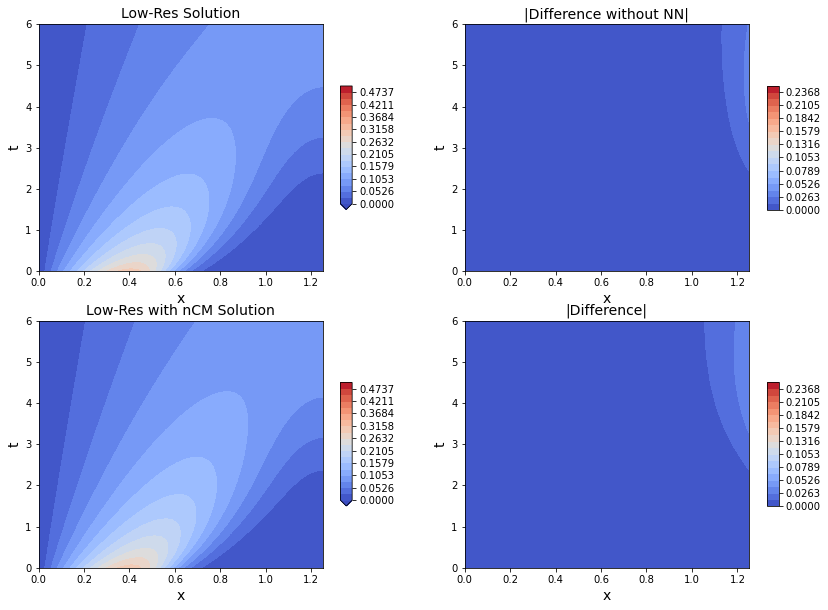

[50, 50, 0.037722085]
High resolution model done!
Low resolution model done!


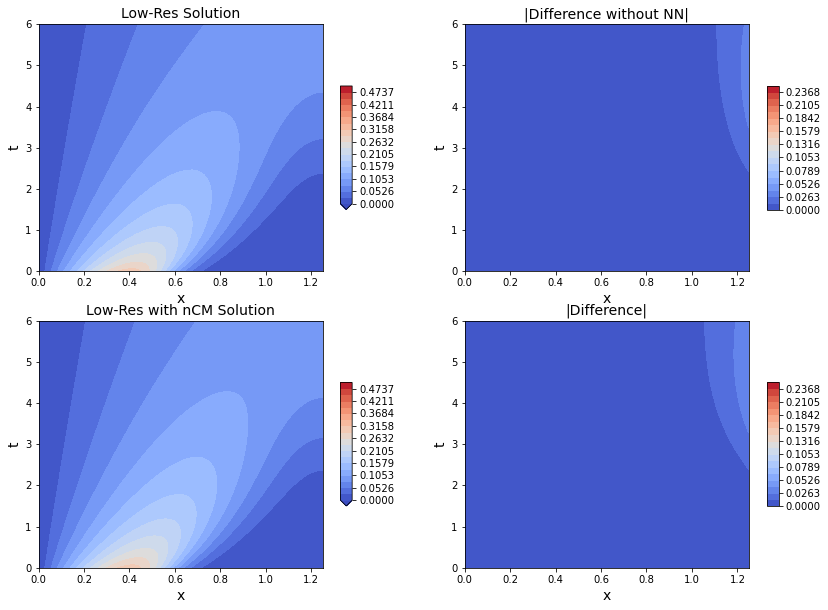

[75, 50, 0.045310263]
High resolution model done!
Low resolution model done!


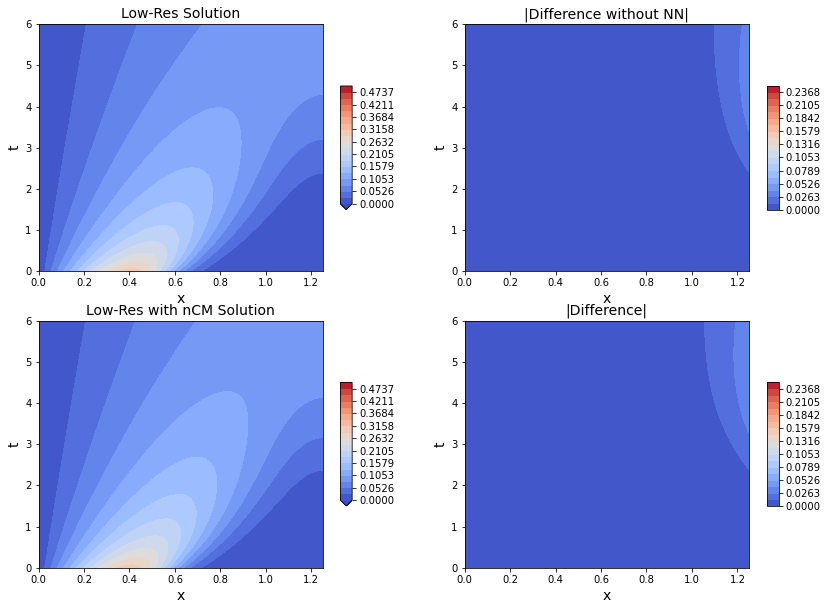

[100, 50, 0.051800765]
High resolution model done!
Low resolution model done!


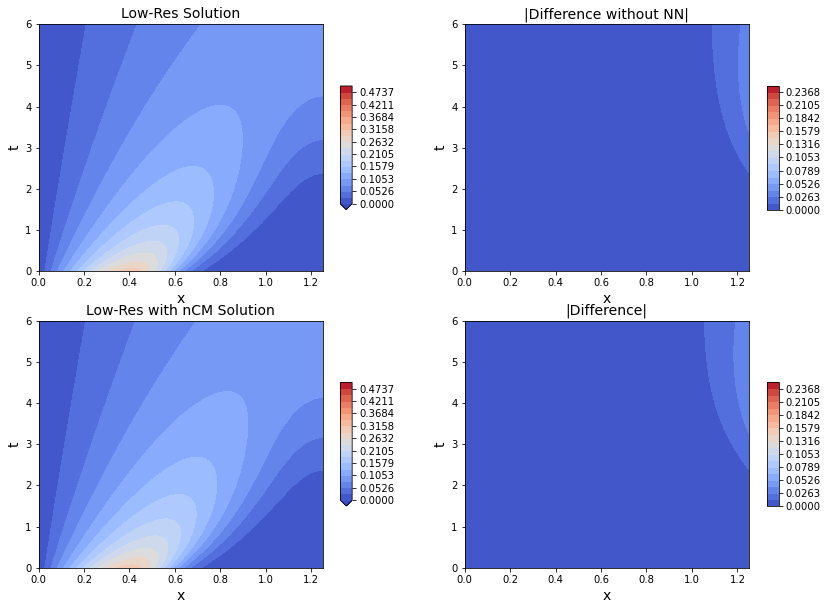

[125, 50, 0.057564393]
High resolution model done!
Low resolution model done!


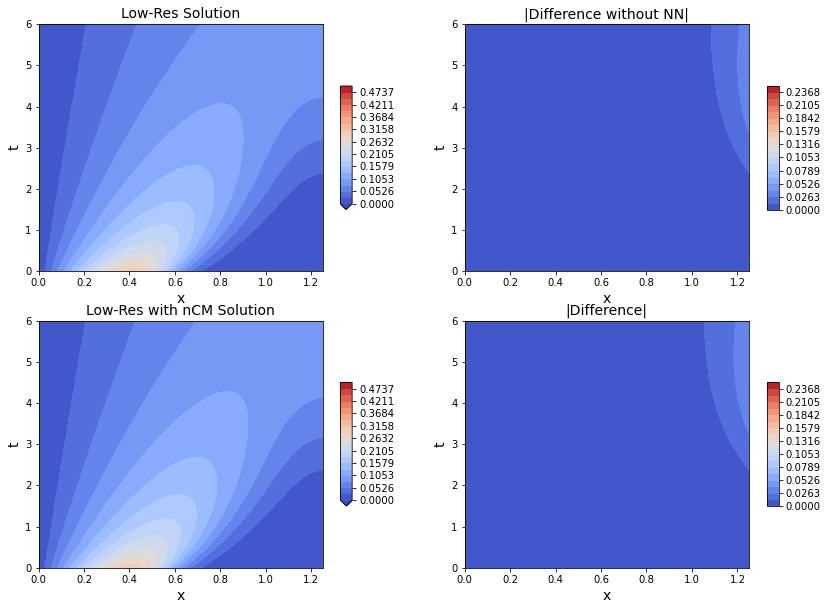

[150, 50, 0.06279856]
High resolution model done!
Low resolution model done!


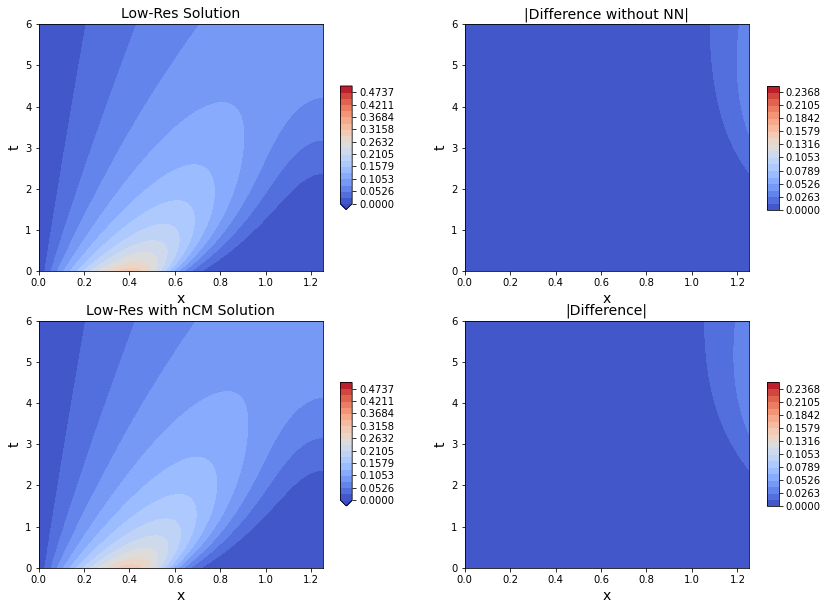

[175, 50, 0.0676298]
High resolution model done!
Low resolution model done!


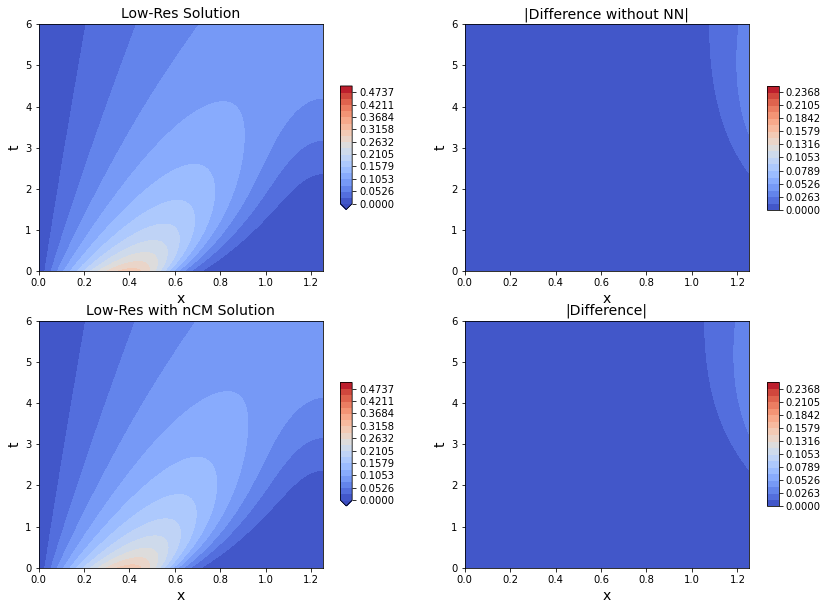

[200, 50, 0.07213716]
High resolution model done!
Low resolution model done!


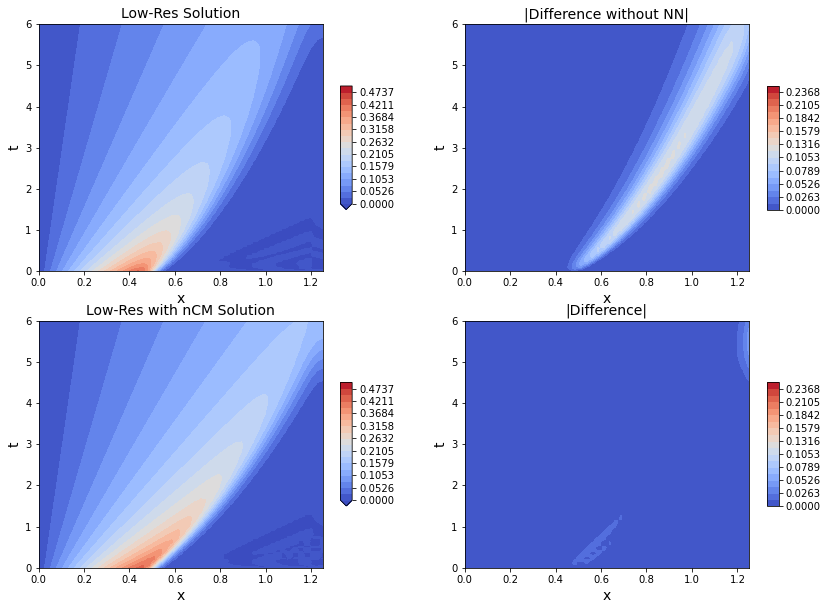

[50, 250, 0.023311429]
High resolution model done!
Low resolution model done!


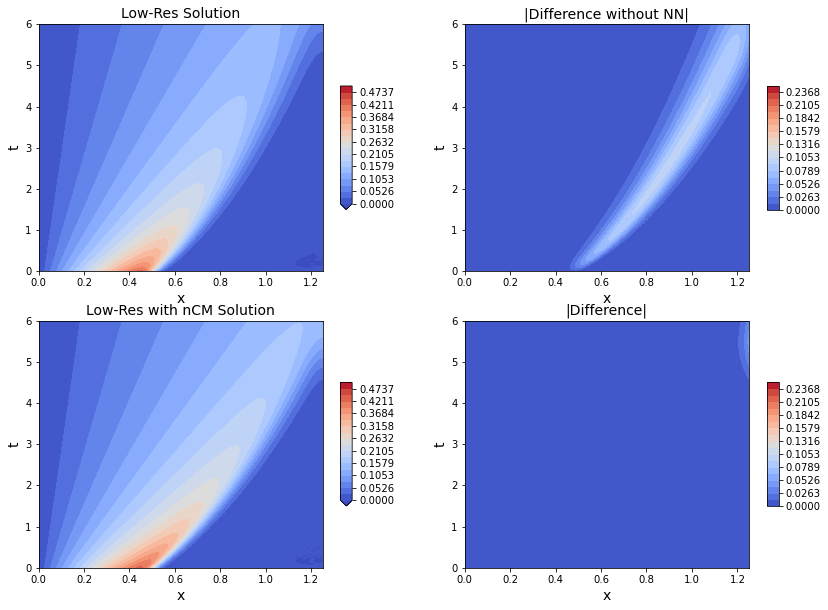

[75, 250, 0.016526211]
High resolution model done!
Low resolution model done!


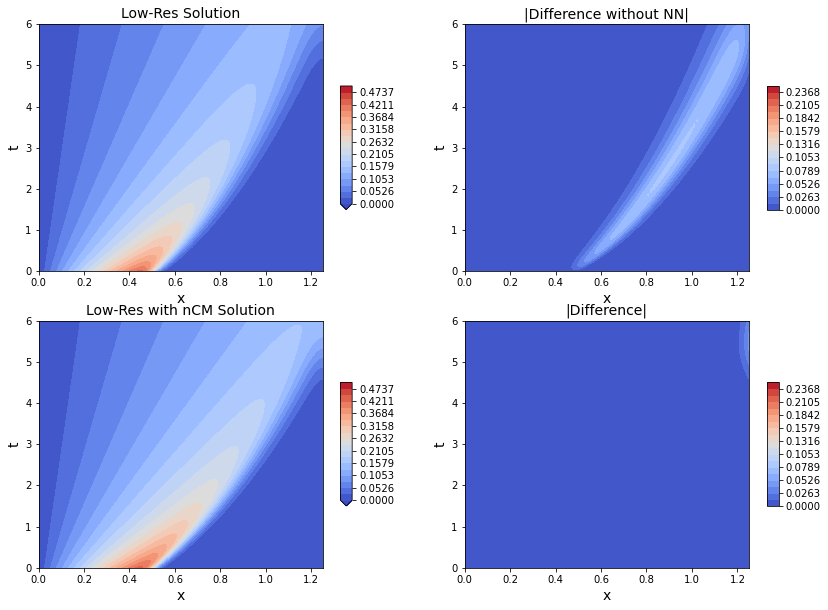

[100, 250, 0.015347857]
High resolution model done!
Low resolution model done!


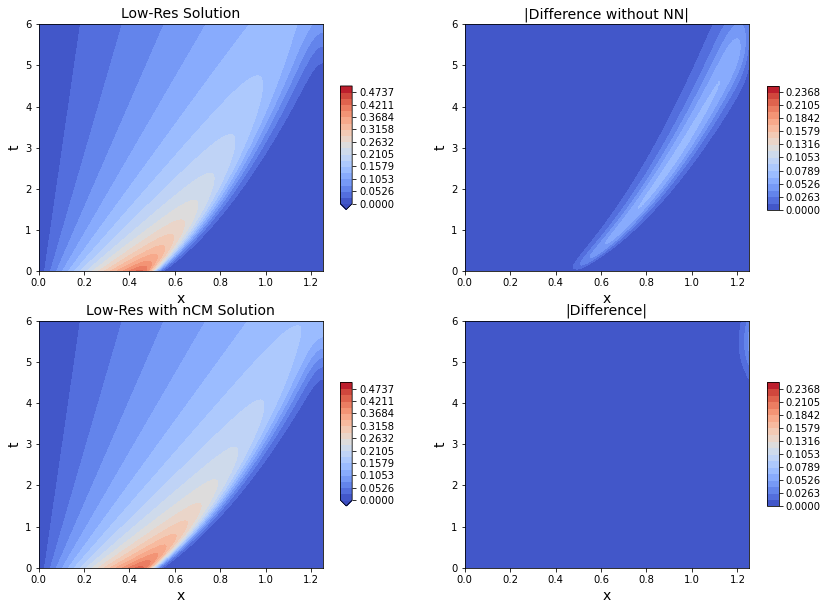

[125, 250, 0.015338618]
High resolution model done!
Low resolution model done!


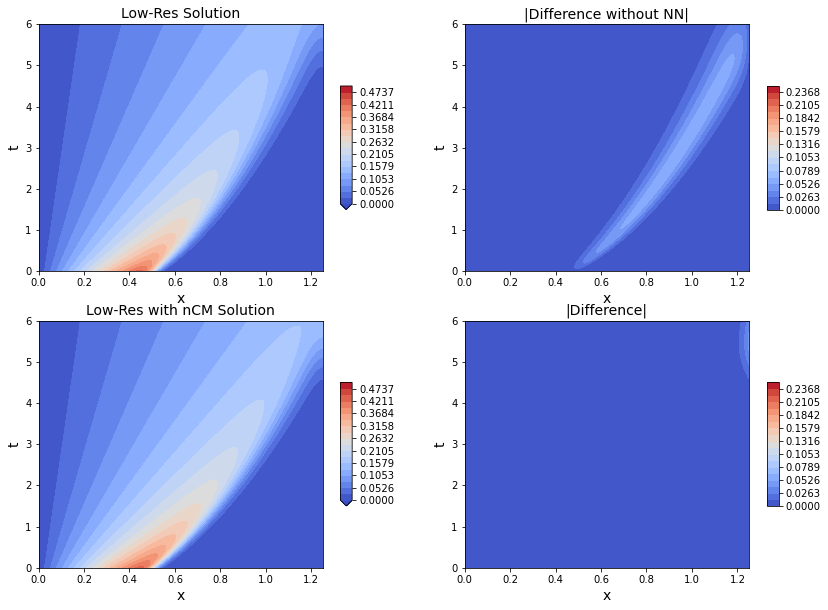

[150, 250, 0.01571861]
High resolution model done!
Low resolution model done!


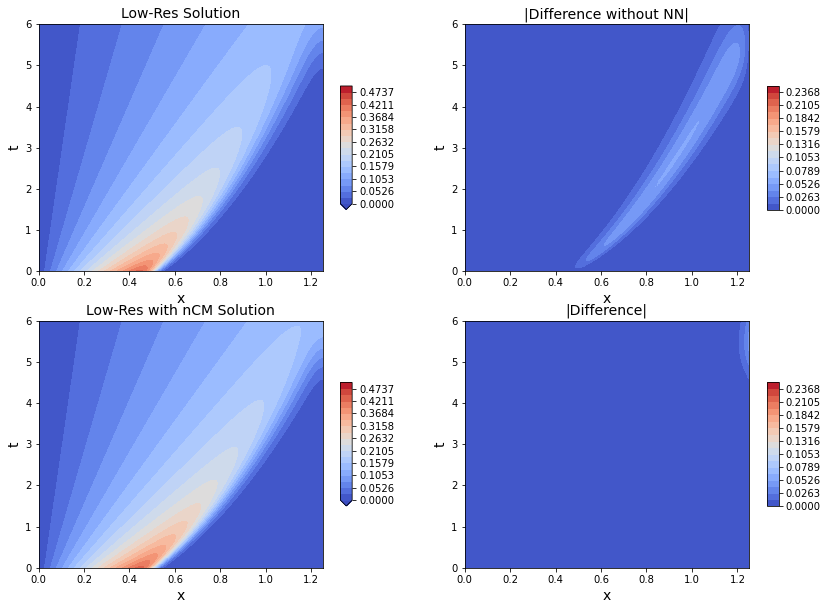

[175, 250, 0.016255919]
High resolution model done!
Low resolution model done!


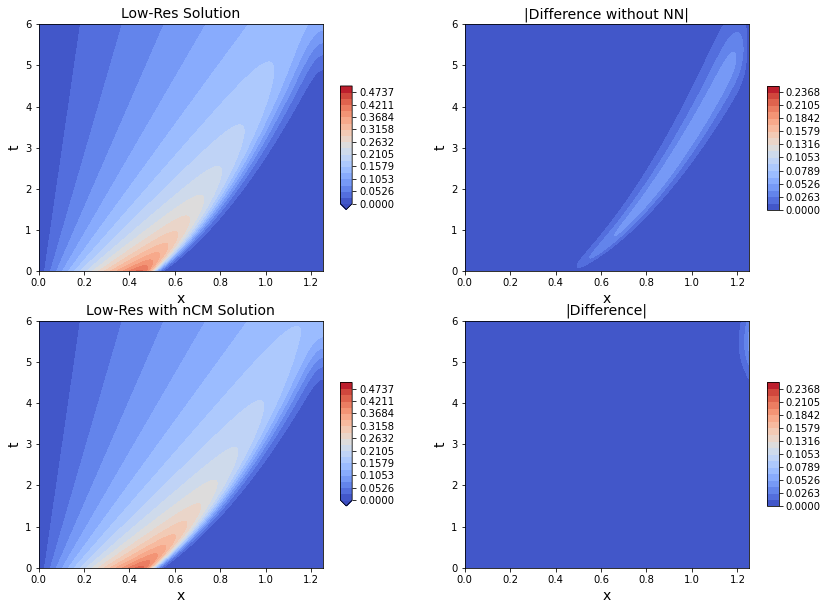

[200, 250, 0.016861299]
High resolution model done!
Low resolution model done!


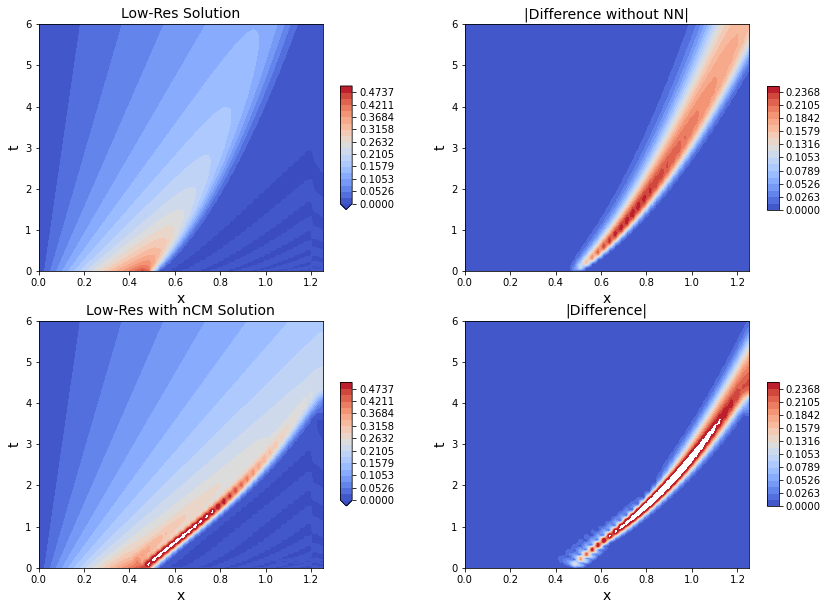

[50, 500, 0.36015052]
High resolution model done!
Low resolution model done!


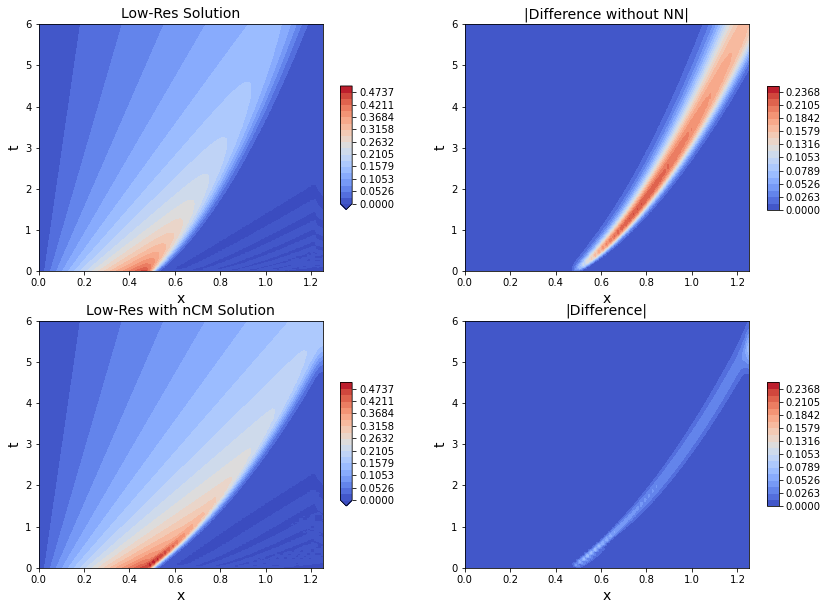

[75, 500, 0.063991584]
High resolution model done!
Low resolution model done!


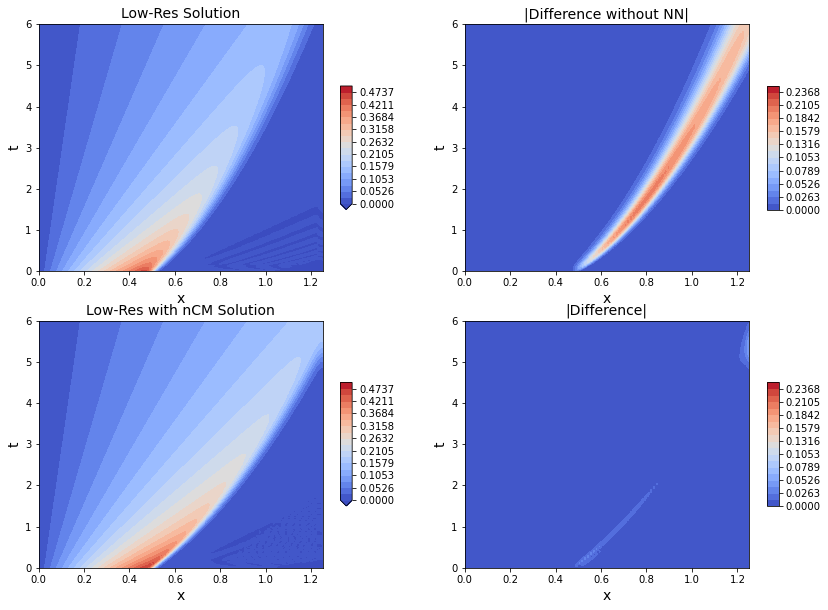

[100, 500, 0.029050687]
High resolution model done!
Low resolution model done!


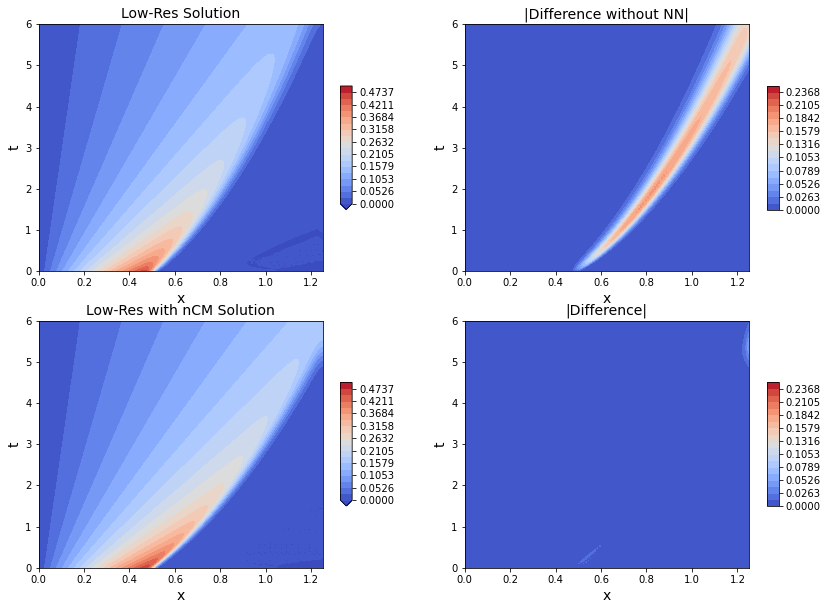

[125, 500, 0.019151602]
High resolution model done!
Low resolution model done!


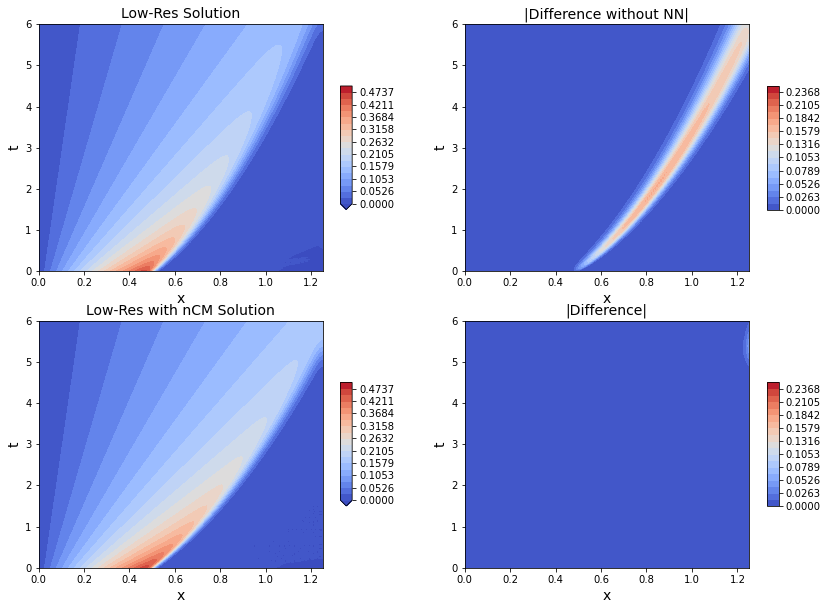

[150, 500, 0.0151249375]
High resolution model done!
Low resolution model done!


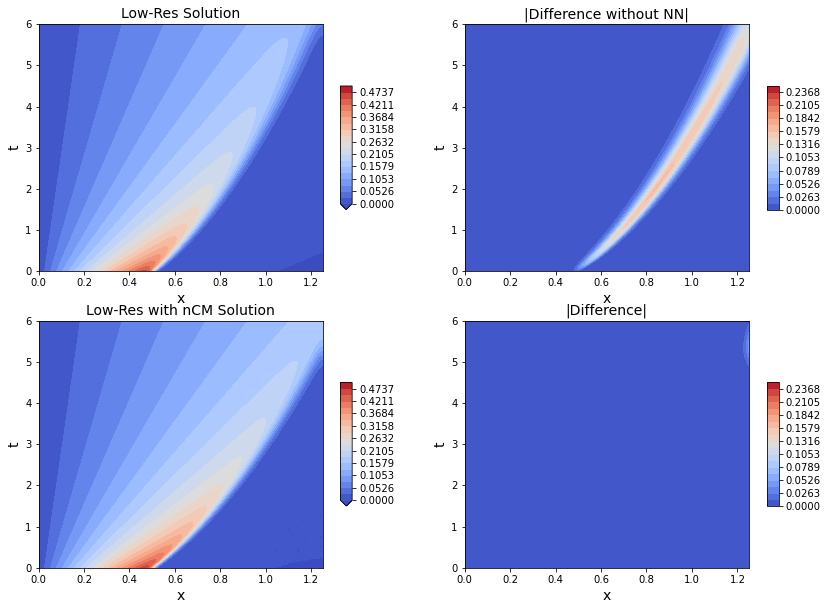

[175, 500, 0.013179887]
High resolution model done!
Low resolution model done!


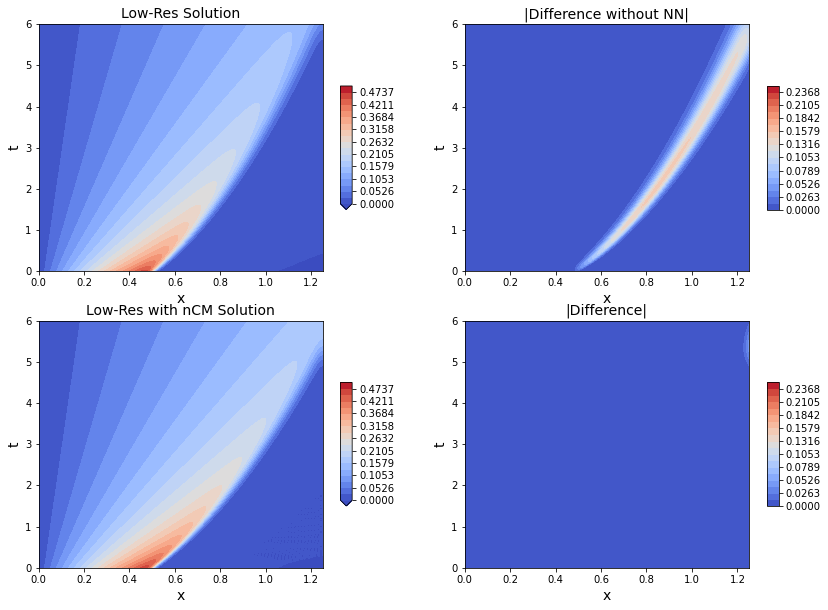

[200, 500, 0.012160434]
High resolution model done!
Low resolution model done!


/home/abhinavgupta0110/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1013: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


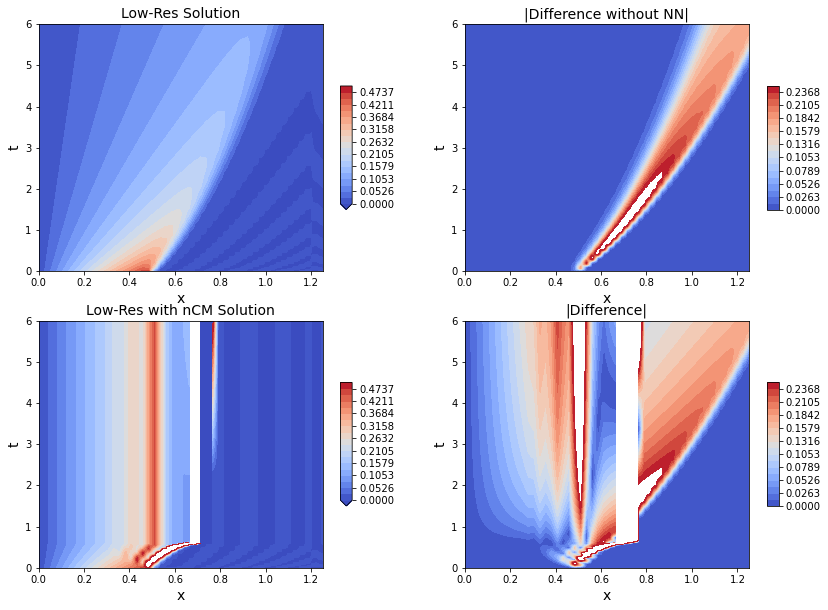

[50, 750, 7.3646586e+18]
High resolution model done!
Low resolution model done!


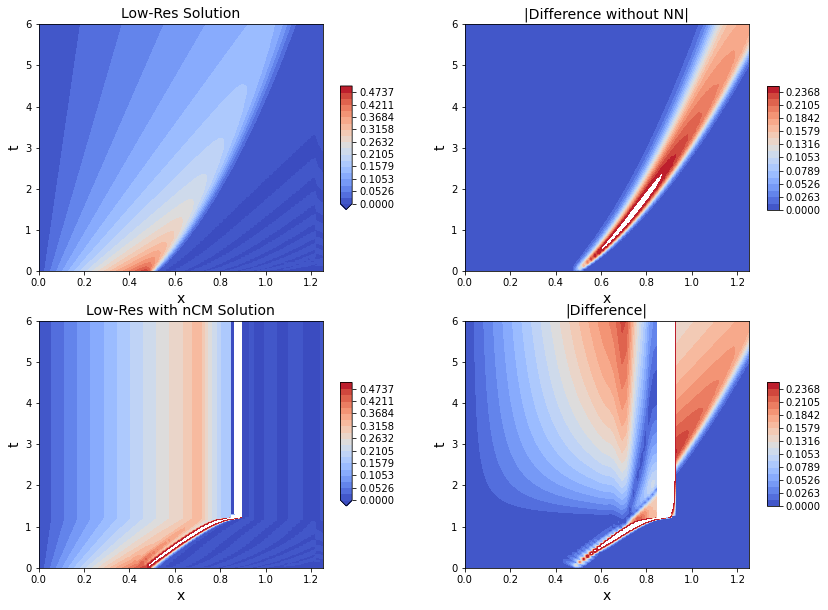

[75, 750, 80290870000000.0]
High resolution model done!
Low resolution model done!


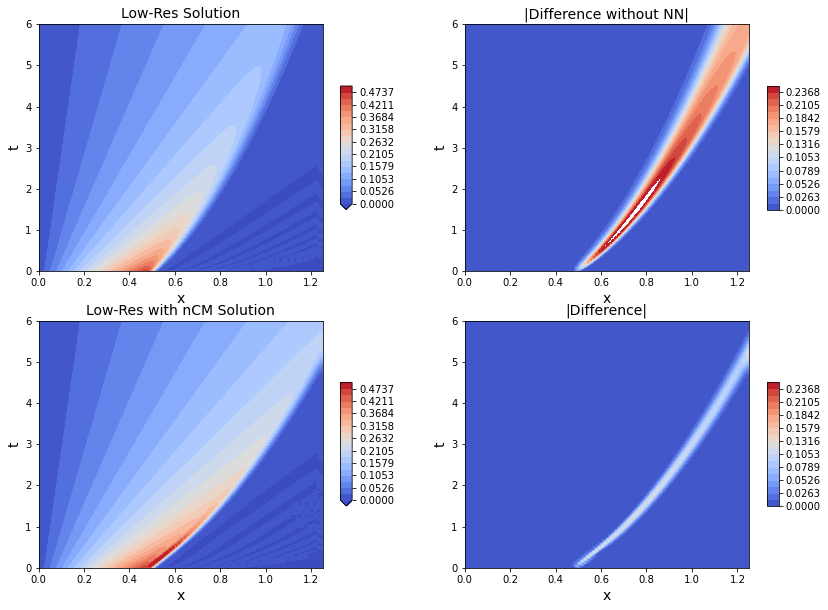

[100, 750, 0.14859761]
High resolution model done!
Low resolution model done!


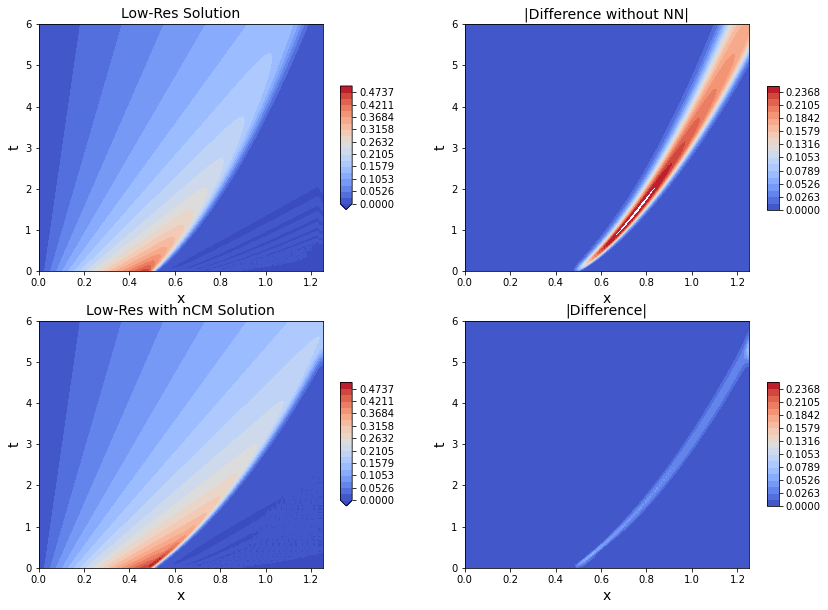

[125, 750, 0.06397236]
High resolution model done!
Low resolution model done!


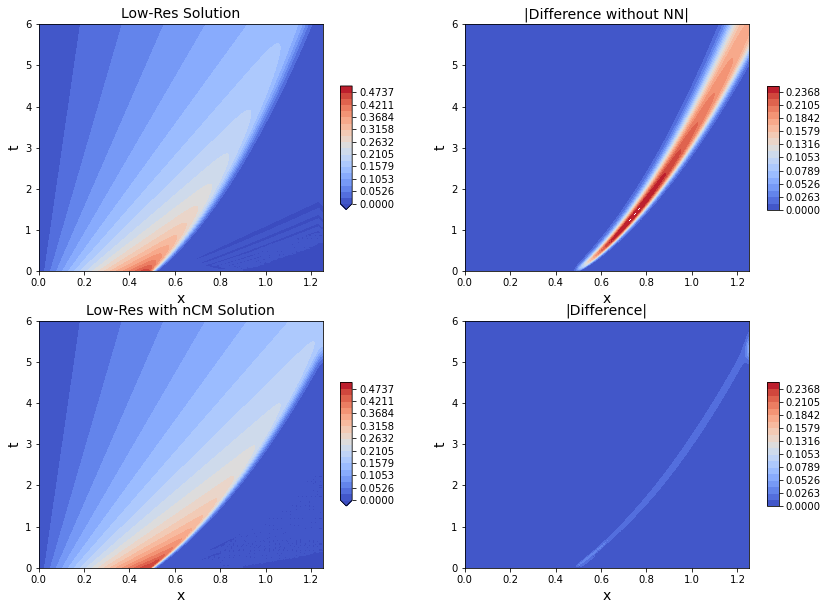

[150, 750, 0.03716907]
High resolution model done!
Low resolution model done!


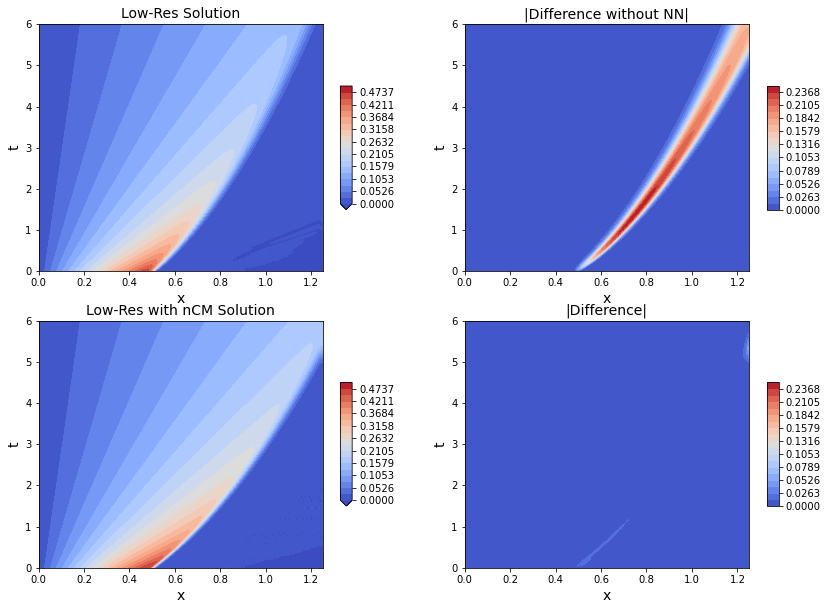

[175, 750, 0.02546551]
High resolution model done!
Low resolution model done!


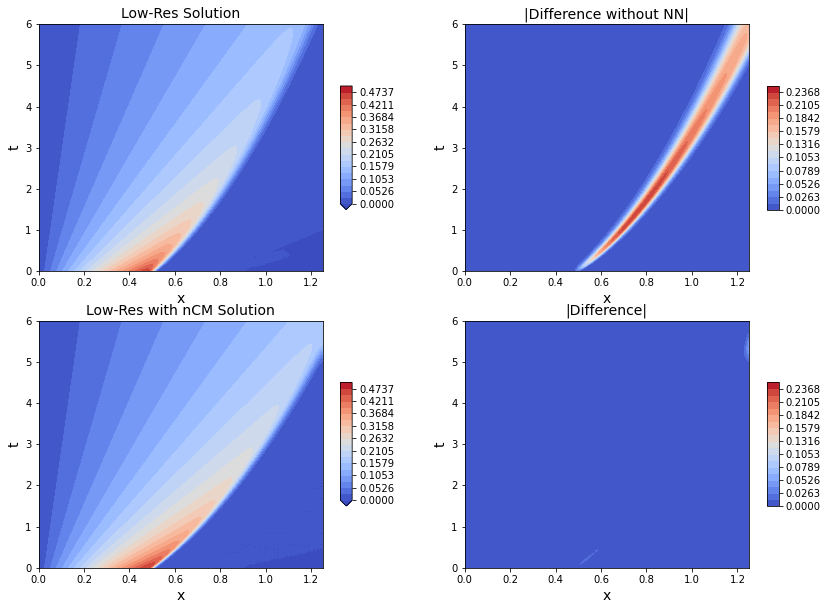

[200, 750, 0.019327242]
High resolution model done!
Low resolution model done!


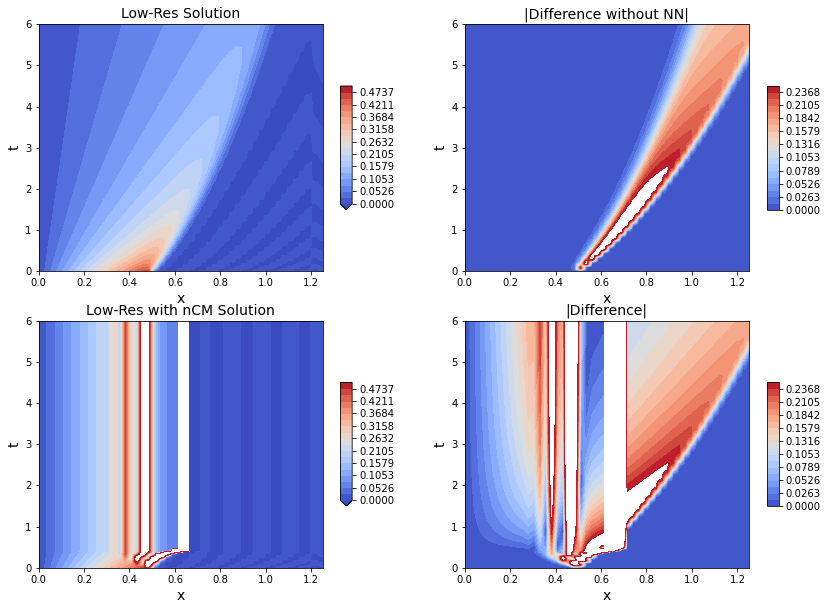

[50, 1000, 670454460000000.0]
High resolution model done!
Low resolution model done!


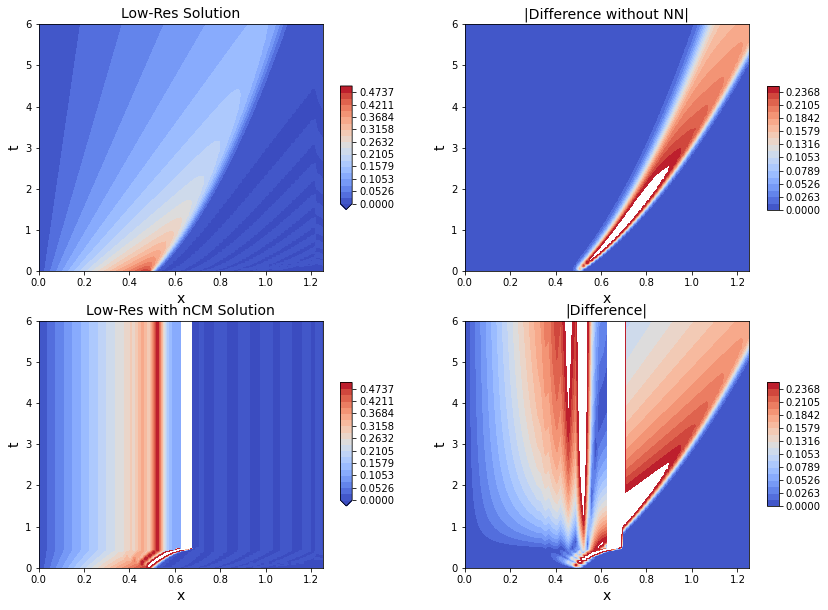

[75, 1000, 1.5750647e+16]
High resolution model done!
Low resolution model done!


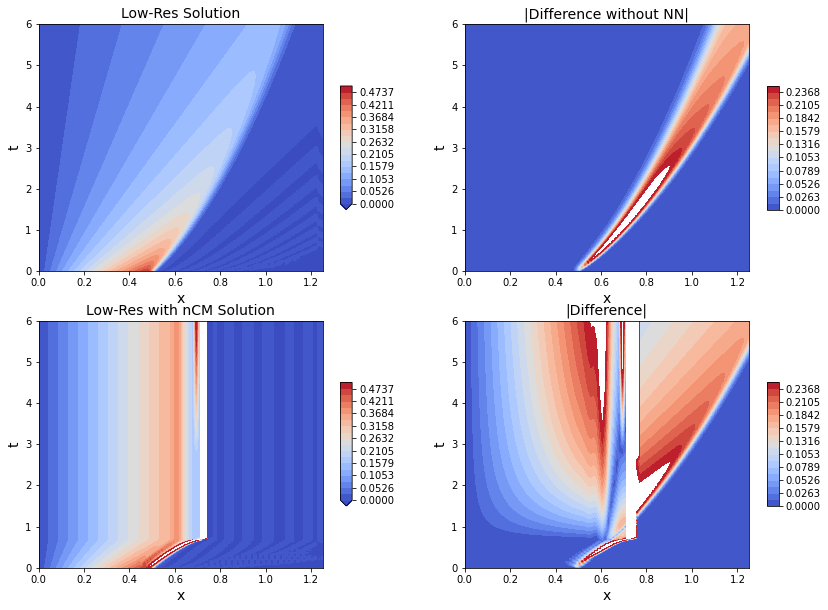

[100, 1000, 2.0655769e+18]
High resolution model done!
Low resolution model done!


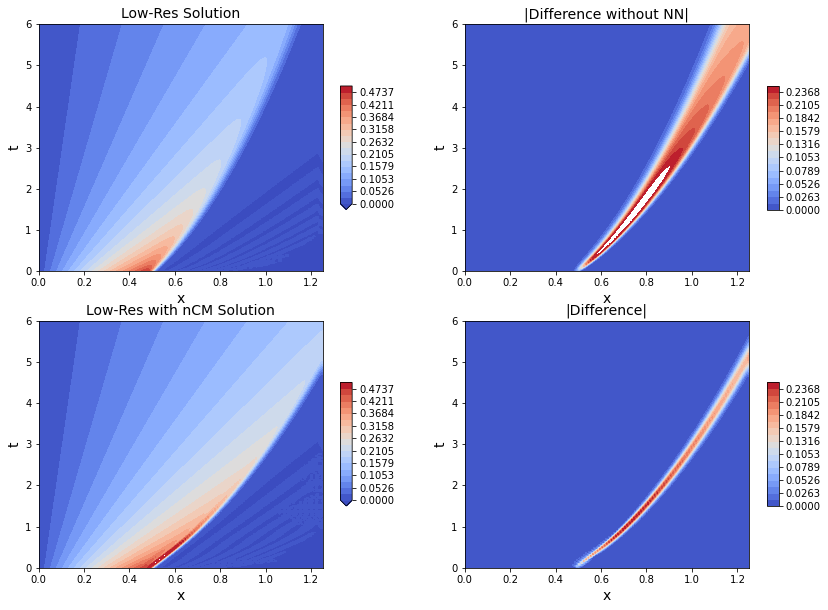

[125, 1000, 0.27337804]
High resolution model done!
Low resolution model done!


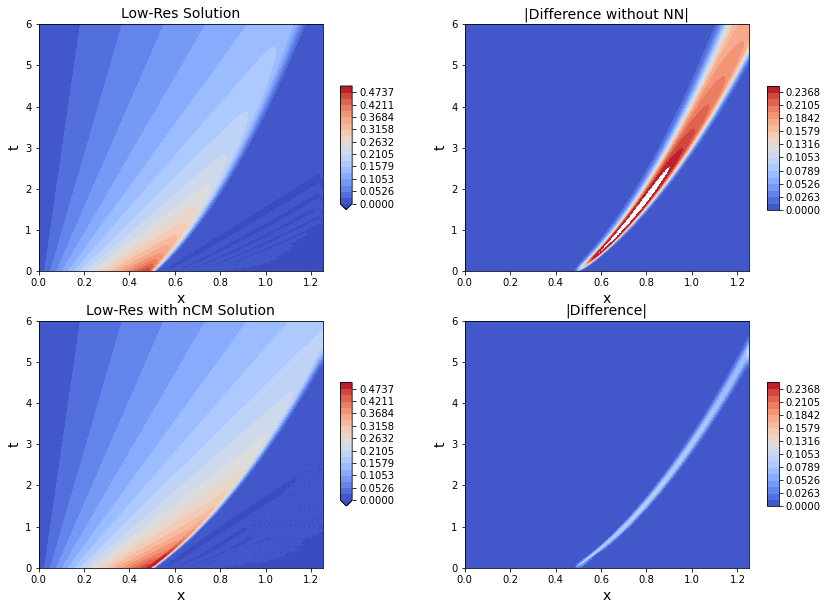

[150, 1000, 0.12311507]
High resolution model done!
Low resolution model done!


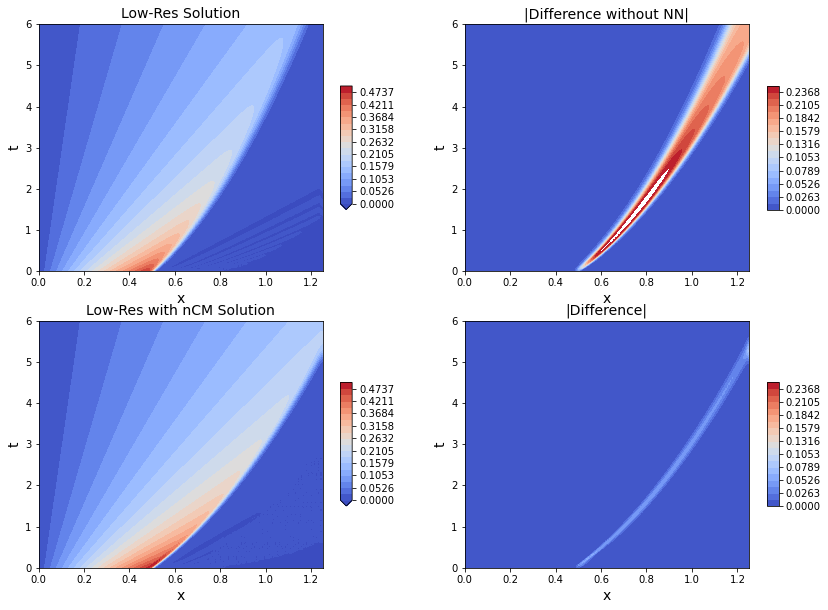

[175, 1000, 0.0704847]
High resolution model done!
Low resolution model done!


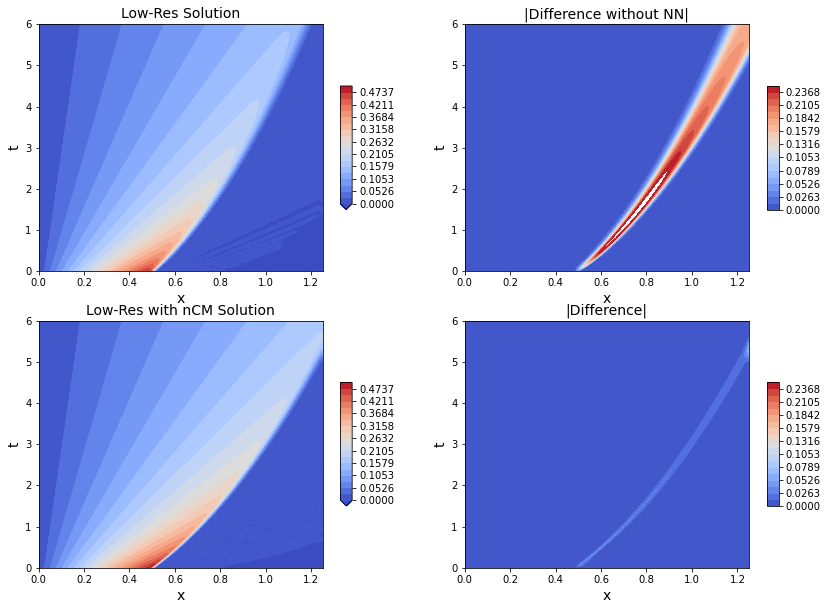

[200, 1000, 0.046552066]
High resolution model done!
Low resolution model done!


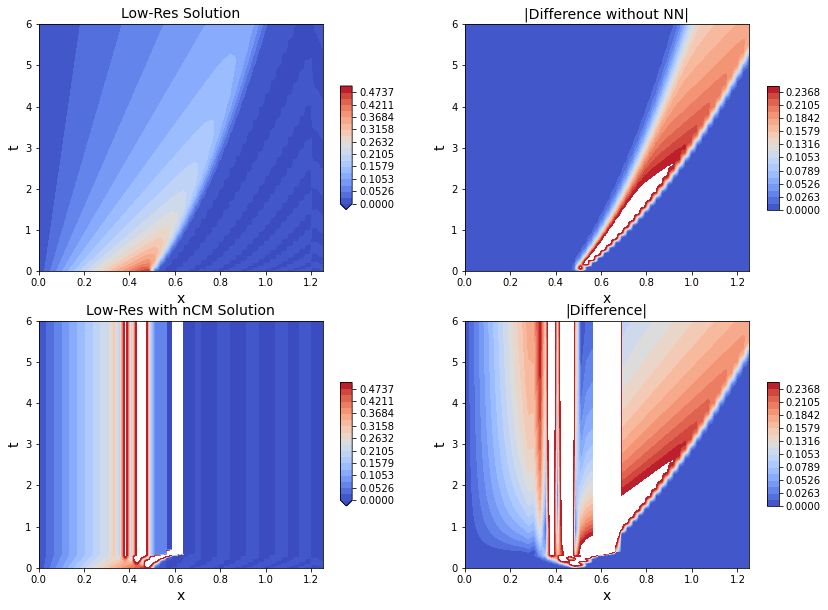

[50, 1250, 687903000000000.0]
High resolution model done!
Low resolution model done!


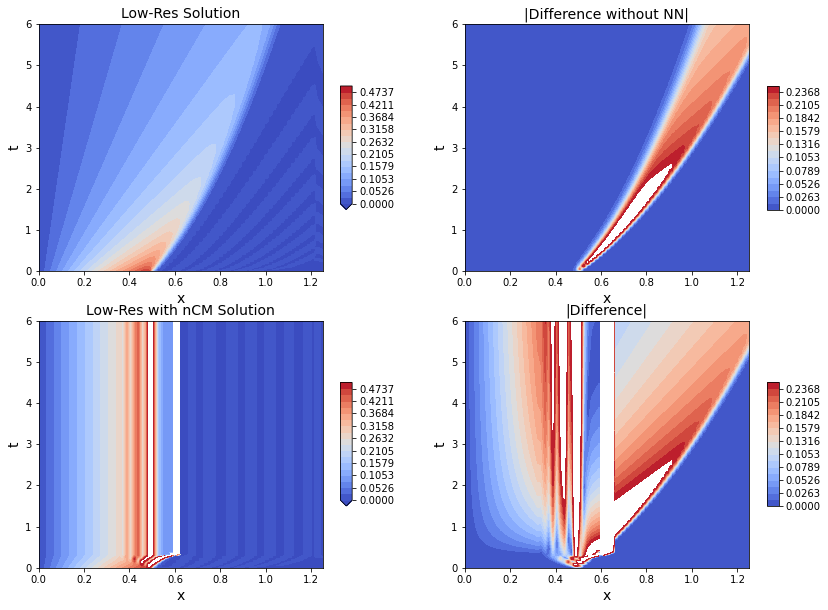

[75, 1250, 3004865400000000.0]
High resolution model done!
Low resolution model done!


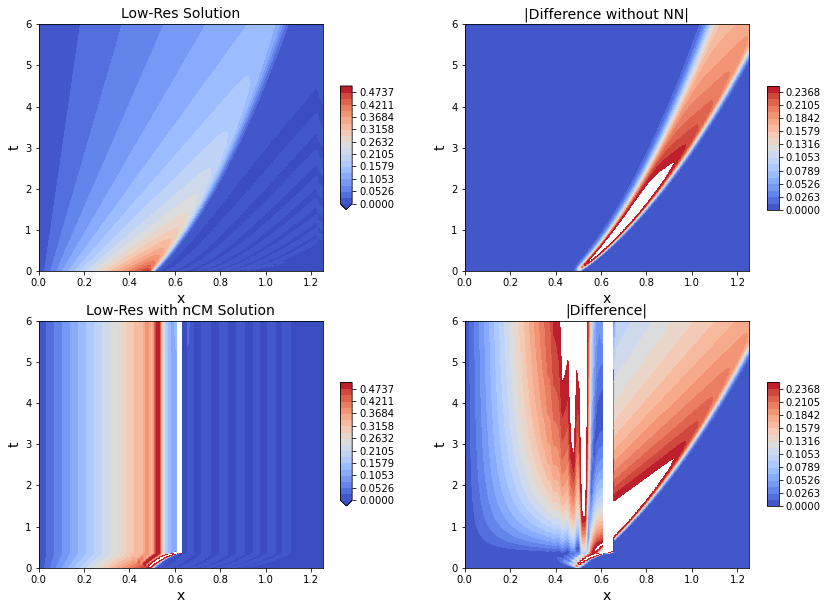

[100, 1250, 6.6490715e+16]
High resolution model done!
Low resolution model done!


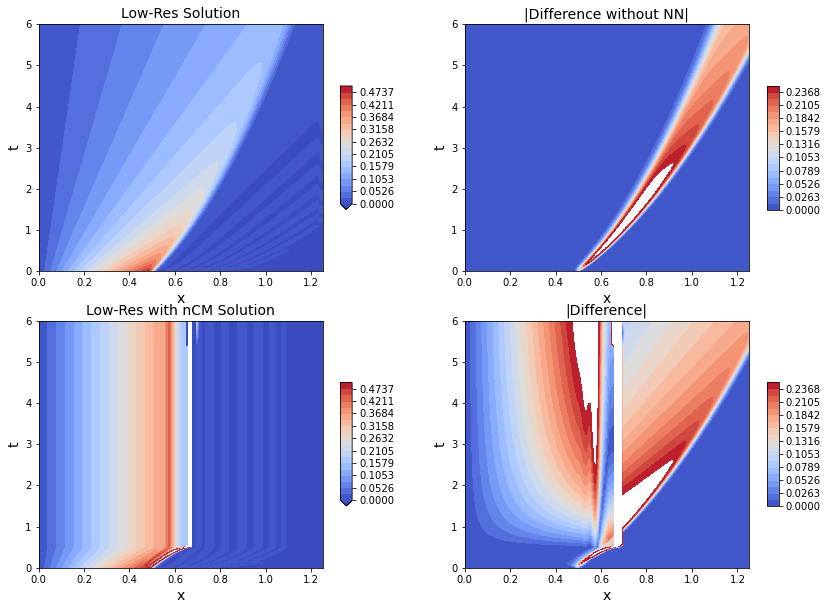

[125, 1250, nan]
High resolution model done!
Low resolution model done!


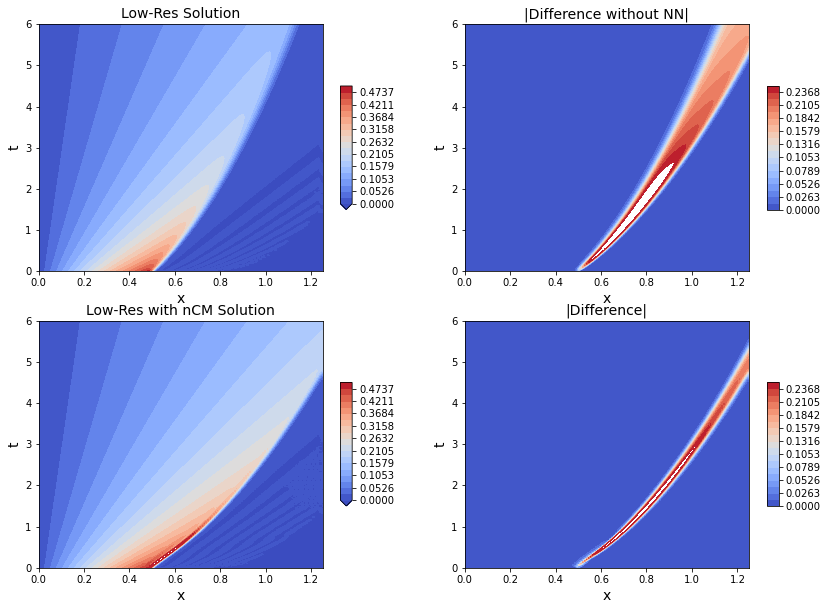

[150, 1250, 0.42349312]
High resolution model done!
Low resolution model done!


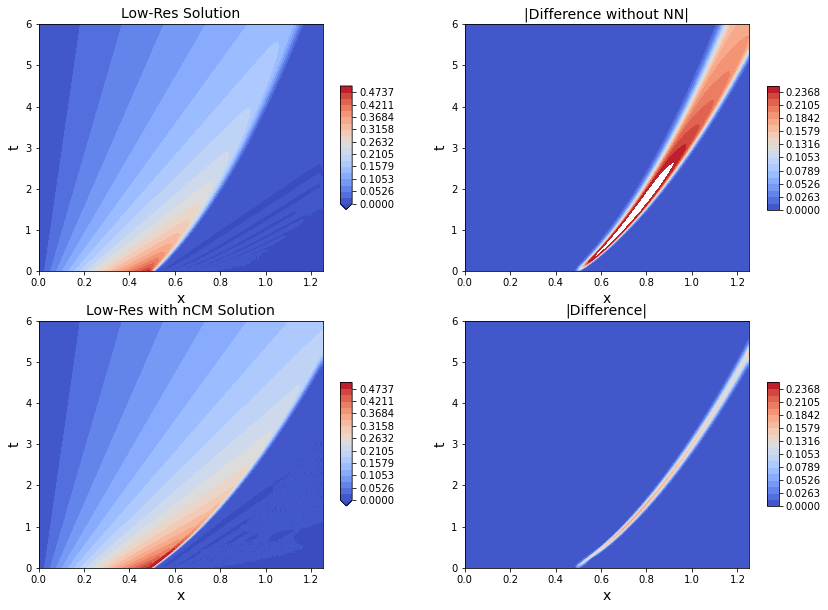

[175, 1250, 0.20558576]
High resolution model done!
Low resolution model done!


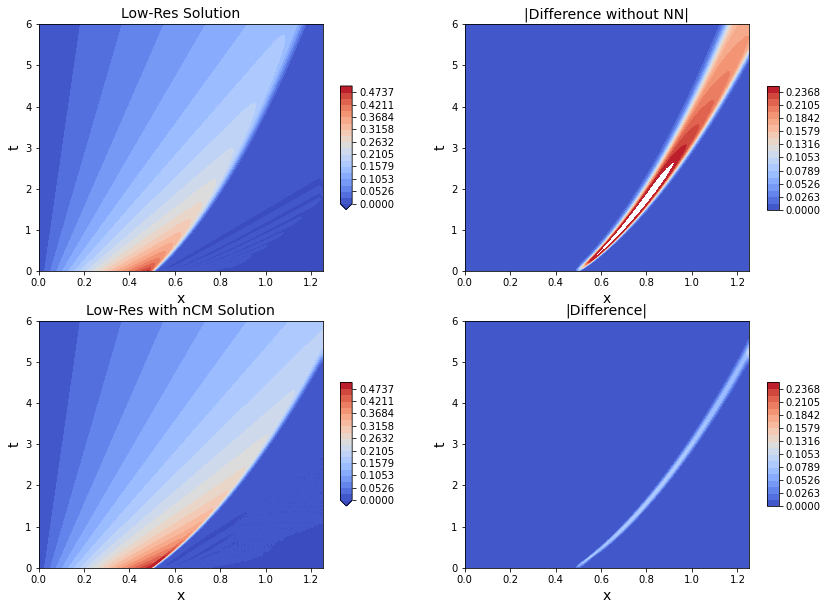

[200, 1250, 0.119962715]
High resolution model done!
Low resolution model done!


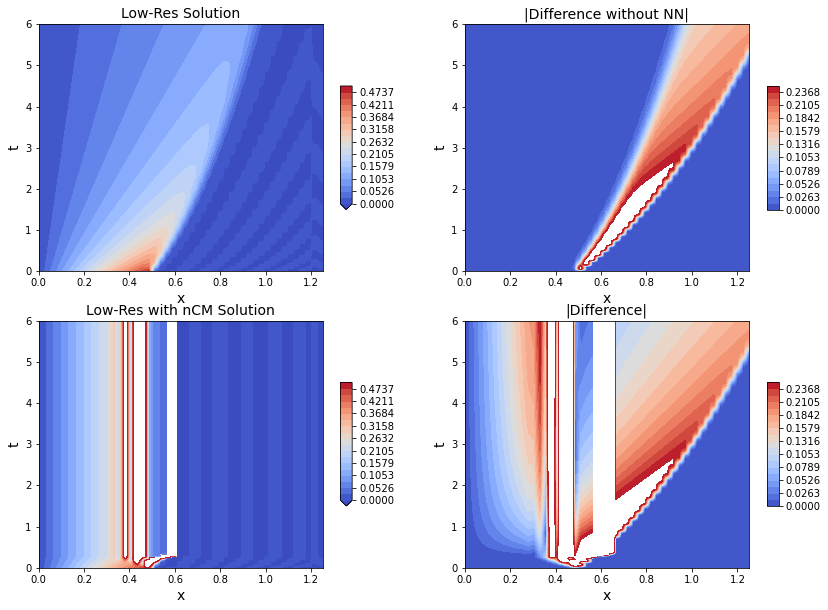

[50, 1500, 1073845100000000.0]
High resolution model done!
Low resolution model done!


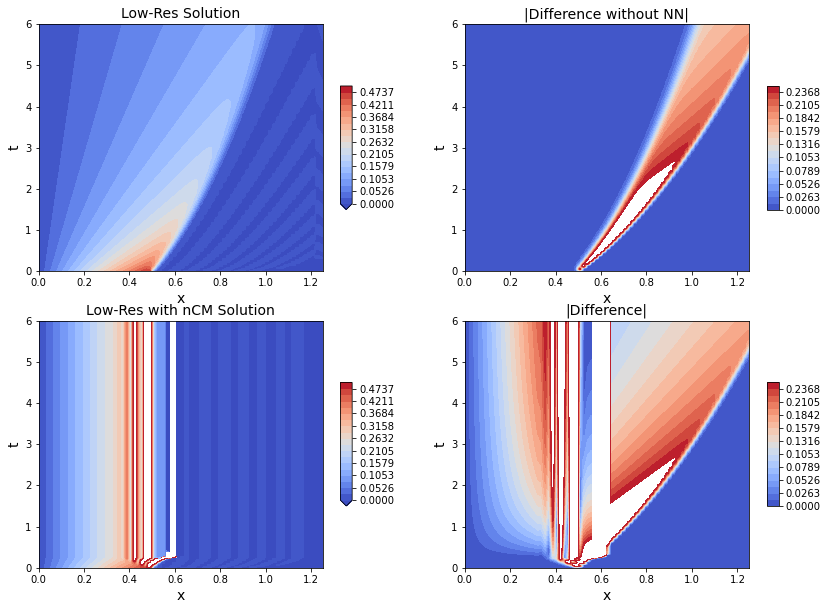

[75, 1500, 2026458300000000.0]
High resolution model done!
Low resolution model done!


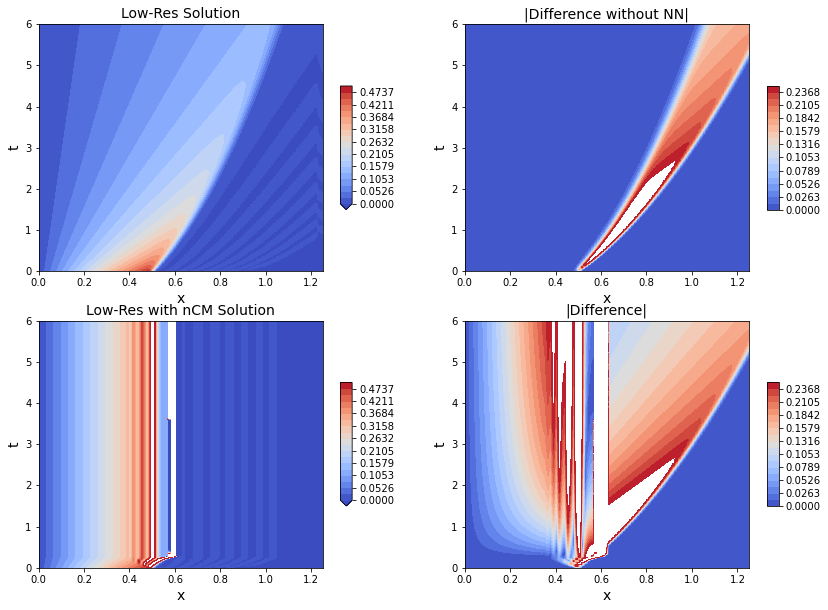

[100, 1500, 2820288000000000.0]
High resolution model done!
Low resolution model done!


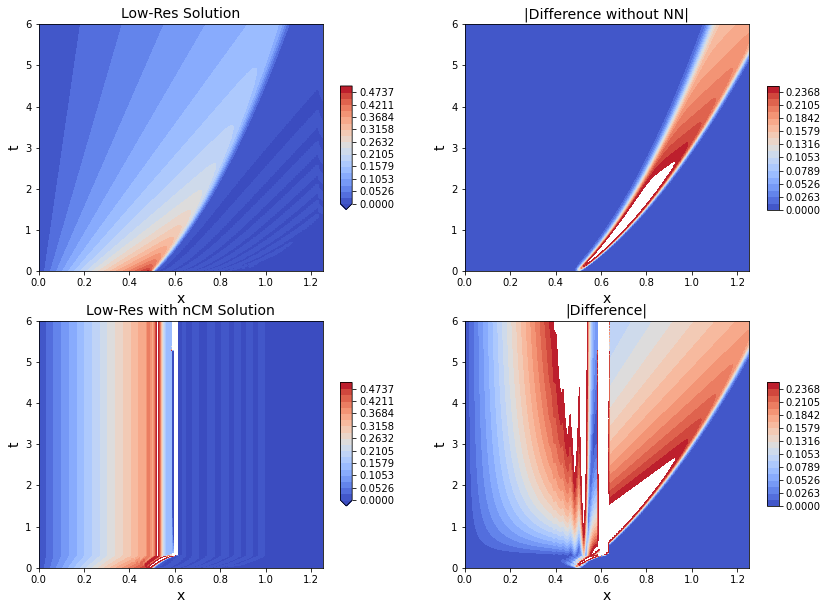

[125, 1500, 8720824000000000.0]
High resolution model done!
Low resolution model done!


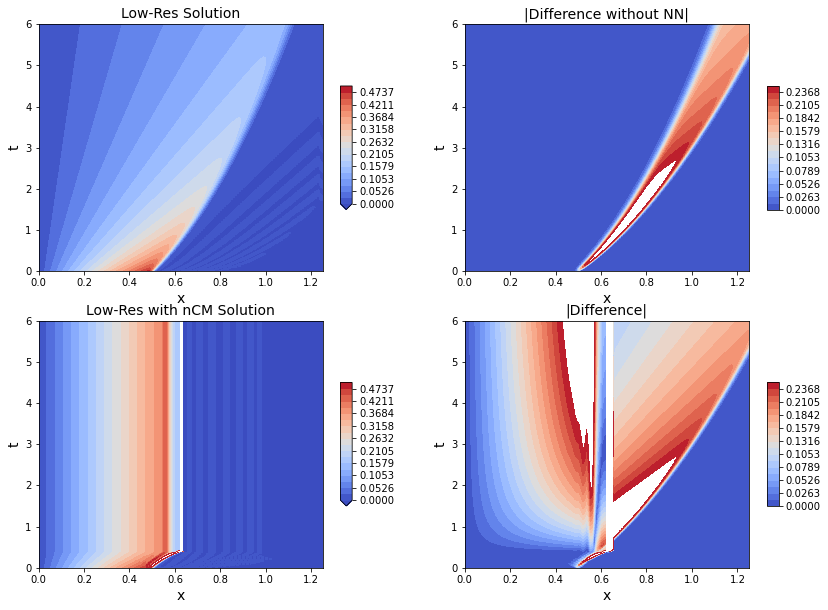

[150, 1500, 536921650000000.0]
High resolution model done!
Low resolution model done!


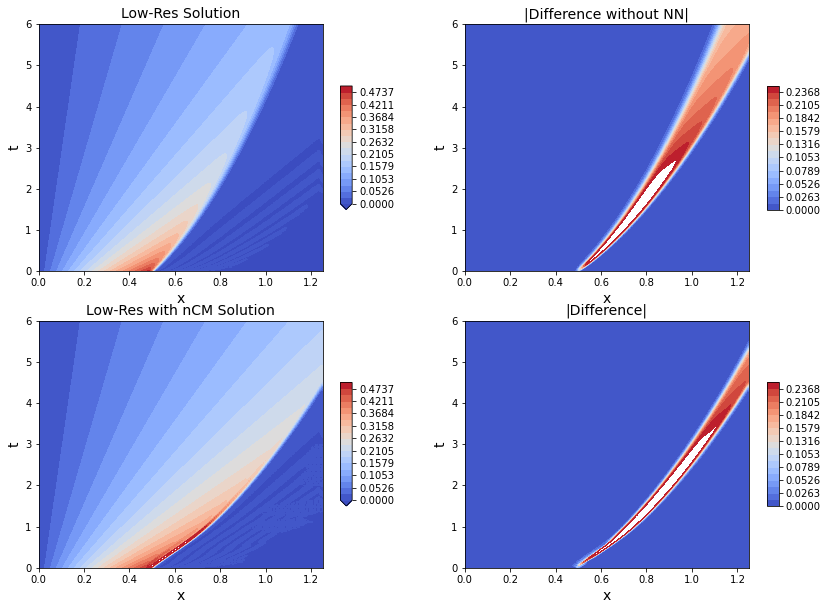

[175, 1500, 0.62446815]
High resolution model done!
Low resolution model done!


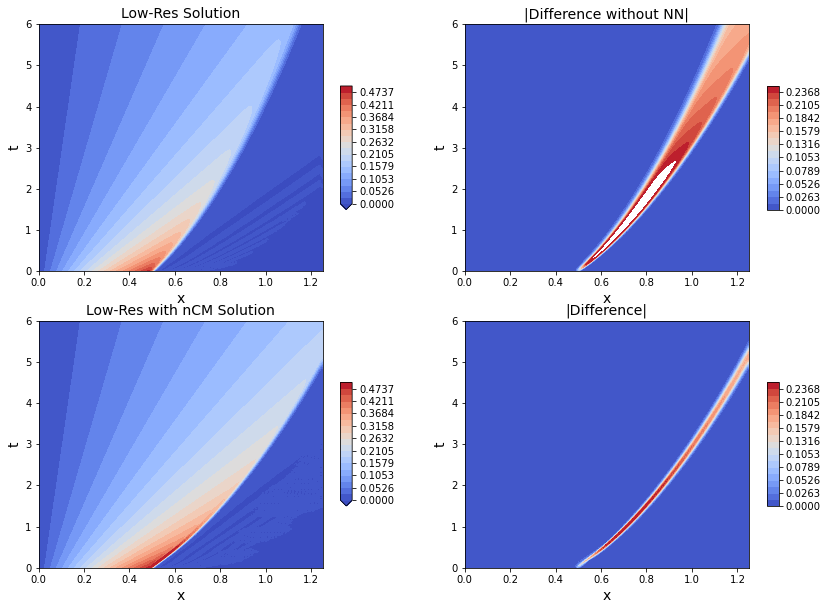

[200, 1500, 0.30533174]


In [11]:
for Re in Re_list:
    for Nx in Nx_list:
        
        args = burg_ncm_args(test_freq = 1, plot_freq = 1, 
                 model_dir = 'burgers_testcase_fd_hots_v2/model_dir_case_analytical', restart = 1, val_percentage = .5,
                 T = 4.0, nt = 400, train_ens_size = 1, x_left = [0.], x_right = [1.25], 
                 nx_train_hf = [250], nx_train_lf = [Nx], Re = [Re], 
                 dleft_bv_dt = [0.], dright_bv_dt = [0.], dbc_l = [1], nbc_l = [0], dbc_r = [0], 
                 nbc_r = [1], isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'vode', nsteps = 100, ens_to_plot = -1, read_hf_data = 0, read_hf_data_fac = 0, 
                 use_analytical_sol = 1, max_deriv = 2, acc = 4, acc_advec = 1)
        
        os.chdir(os.path.join(basedir, testcase_dir))
        %run -i setup

        # create ROM RHS for evaluation
        grid_obj = fdgen.grid(args.args_eval_lf)
        deriv_obj = fdgen.deriv(args.args_eval_lf, grid_obj)

        eval_burg_obj = burg.burg_rhs(args = args.args_eval_lf, deriv_obj = deriv_obj, grid_obj = grid_obj)

        func = DistDDEFunc(eval_burg_obj, args.args_eval_lf, norm_eval)

        plot_obj = custom_plot(tf.concat([true_u_low_res, val_true_u_low_res], axis=0), 
                               tf.concat([u_low_res, val_u_low_res], axis=0), 
                               tf.convert_to_tensor(fdgen.grid(args.args_eval_lf).x_grid_real), 
                               tf.concat([t, val_t], axis=0), save_dir_obj.figsave_dir, args.args_eval_lf, args.restart)

        val_obj = ncm.create_validation_set(true_u0, t, args)

        pred_zy = ddeinttf(func, true_u0, tf.concat([t, val_t], axis=0), fargs=(), alg_name = args.ode_alg_name, nsteps = args.nsteps)

        plot_obj.plot(pred_zy, epoch = 0)

        truth = tf.concat([true_u_low_res, val_true_u_low_res], axis=0)

        err_obj = compute_error(truth)
        
        Nx_Re_error.append([Nx, Re, err_obj.l2_error(pred_zy)[0]])
        
        print(Nx_Re_error[-1])
        

## Main part starts here

### Make objects and define learning-rate schedule

### Plot training time

In [15]:
Nx_array = np.array([Nx_Re_error[i][0] for i in range(len(Nx_Re_error))])
Nx_array = np.reshape(Nx_array, [len(Re_list), -1])

Re_array = np.array([Nx_Re_error[i][1] for i in range(len(Nx_Re_error))])
Re_array = np.reshape(Re_array, [len(Re_list), -1])

error_array = np.array([Nx_Re_error[i][2] for i in range(len(Nx_Re_error))])
error_array = np.reshape(error_array, [len(Re_list), -1])
error_array[np.isnan(error_array)] = 1e16

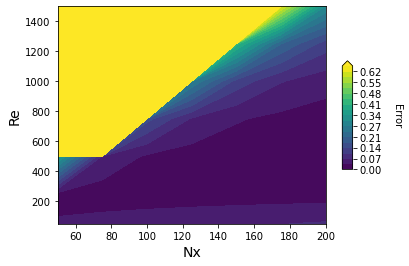

In [18]:
plot = plt.contourf(Nx_array, Re_array, error_array, levels=np.linspace(0, 0.65, 20), extend='max')
cbar = plt.colorbar(plot, shrink=0.5, aspect=10, format='%.2f')
plt.xlabel('Nx', fontsize=14)
plt.ylabel('Re', fontsize=14)
cbar.set_label('Error', rotation=270, labelpad=20)